# Our Final DLL Exercise
After you complete this, you are going to dive into your own projects and try to get the best possible results, coolest looking artworks, most interesting insights, or whatever you are working on. This exercise is to get a little hands on experience with some of the basics. For some of you this will likely be a bit redundant, but I hope we can get you all on "the same page" with this exercise. Even if you think it is useless, even for me it was refreshing to go through basic trainings again and re-evaluate some ideas I had so far. So please have a look at the exercise regardless of how advanced your knowledge is already.

We will train several models on the CIFAR-10 dataset, starting from a tiny MLP and ending with a full-fledged ResNet. The resulting performances are not the main interesting point of this exercise. It's mostly about comparing models and seeing how they behave differently. I used PyTorch for this, obviously you could redo it all in another framework, but learning multiple frameworks is a good idea. It gives you a feeling for advantages and disadvantages of the different frameworks. I must admit that I haven't worked with PyTorch a lot so far, but I was able to pull this off in some hours. Even if you have no experience, you should be able to fill in the blanks I left for you to complete. Nevertheless, some of the things might not be the best way to go, but everything should be good enough to actually run the interesting deep learning experiments. Any feedback is very welcome and I hope we can have some cool discussions next week!

For every block of experiments, there is a short intro text, explaining what to do and some code to help you get started. In each block there are some interesting questions that you should try to answer for yourselves, or some additional directions that you might want to look into. While we will have a look at your resulting notebooks in the gitlab, we will not check if you answered the interesting questions, I can just recommend to play around with these things though. I tried to document most of the things I did in a pretty "extreme fashion" so it is trivial to understand what is going wrong. Here and there I added suggestions for what you could change.


## Where to run
You can run all of this on a CPU, potentially even extracting the code and scheduling it on the cluster, or, for now, you could run the notebook on Google Colab. I tested most of the code on there and it runs fine using one of their GPUs (attention: by default you only get a cpu instance). Their GPU use is limited though. I was kicked out after some hours of training. It will also run on the CPU, but it takes a bit more time. Hence it is a good idea to start working on this early.

On Colab run the following to install missing packages, all other packages should be pre-installed. If you run this on a local machine, make sure you have all other packages imported below installed.


In [ ]:
!pip install einops
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 47.3 MB/s 
     |████████████████████████████████| 144 kB 39.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=7d1ed4fff814dbdd2f64bf6c37f87bacd453339a351e5ec31379170f3d1665b2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
# Torch for all the neural network stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

# Torch vision for easily loading datasets
import torchvision
import torchvision.transforms as transforms

# A progress bar to show progress during training
from fastprogress import master_bar, progress_bar

# Numpy for some matrix manipulations
import numpy as np

# Matplotlib for showing pictures
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
font = {'size': 22}
mpl.rc('font', **font)

# Einops in order to easily rearrange tensors.
# We here use it for a trivial example, but it works for
# PyTorch and TF too, so have a look at it.
from einops import rearrange

# Loading the data
We will be training on CIFAR10.
As a first step, load the data and setup code to fetch batches. PyTorch provides easy utilities for all of this, including easily downloading the data and storing it.

Especially for very simple networks, it is important to normalize the data, so first compute the mean and standard deviation of the training set in order to later normalize the data to have zero mean and unit variance. (Hint, when loading images, PyTorch already normalizes them to be in a 0 to 1 range).

Finally, create a `DataLoader` for both the training and test set with the appropriate `transforms`.

If you have no idea where to start, the PyTorch basic tutorials will get you very far!

In [ ]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

cifar_mean = np.mean(cifar_trainset.data)
cifar_std = np.std(cifar_trainset.data)

print("CIFAR10 mean: " + str(cifar_mean))
print("CIFAR10 std:  " + str(cifar_std))

Files already downloaded and verified
CIFAR10 mean: 120.70756512369792
CIFAR10 std:  64.1500758911213


In [ ]:
batch_size_train = 128
batch_size_test = 100

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Looking at the data
It's always a good idea to have a quick look at the data, is something going terribly wrong with the augmentations? Are the labels loaded correctly?

The below code plots a single batch. Executing it again will show a new batch every time, but each of them should look valid. Cycle through a few batches so you get a feeling for the data. Can you actually recognize the classes yourselves?

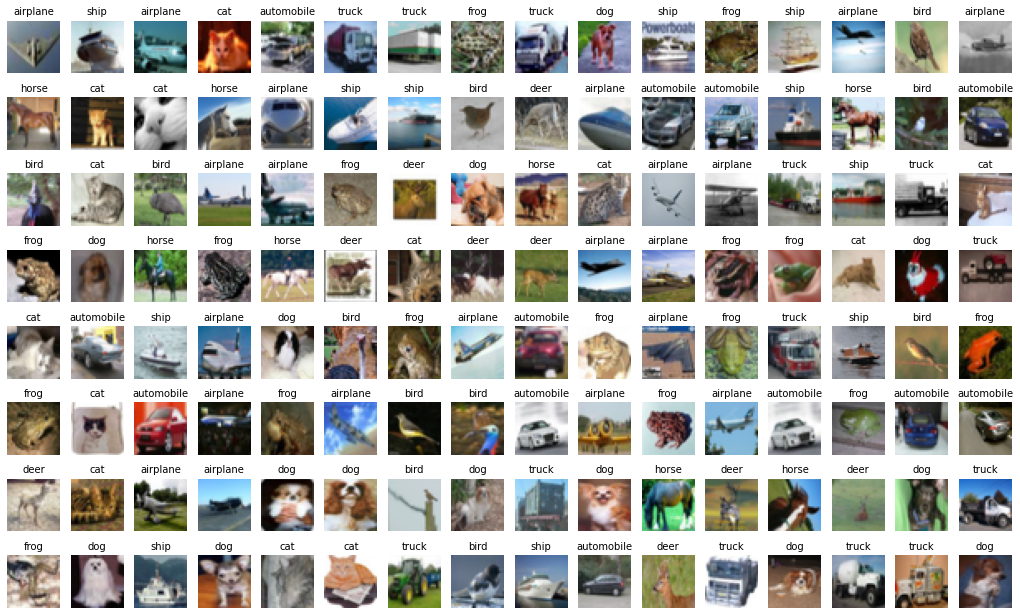

In [ ]:
train_batch = next(iter(train_loader))
fig, axes = plt.subplots(8, 16, figsize=(18,11))

for axis, image, label in zip(axes.flatten(), train_batch[0], train_batch[1]):
    # We first need to undo the normalization (mean/std), rearrange the channel 
    # dimension to the back, and finally clip the image to between 0 and 1.
    # Due to augmentations some of them might have smaller/larger values.
    image = np.clip(
        #rearrange(image, 'c h w -> h w c') * cifar_std + cifar_mean, 0,1)
        rearrange(image, 'c h w -> h w c'), 0,1)
    axis.imshow(image)
    axis.set_axis_off()
    axis.set_title(train_set.classes[label], fontsize=10)

# Setting up a monitoring tool
There are many ways to monitor the training progress, starting at simple print outs in a loop, dynamic plotting, a local logging tool such as tensorboard, or an online tool such as weights and biases.

Here we will log stuff with weights and biases, which requires an account (free). Feel free to change this to something else, for that it should suffice to modify the below training function. In the worst case you can just comment out any weights and biases specific code.

If you do use weights and biases, I would be very excited to have a look at your training progress, don't worry, I won't judge any failed attempts. I used my google account to login to wandb, consider inviting me to look at your training logs (alexander.hermans0@gmail.com, no, the 0 isn't a typo).

In [ ]:
import wandb

In [ ]:
wandb.login() # Click on the link and enter your authorization code.

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Checking if we are using a GPU
Let's quickly check our setup, optimally we should get a GPU, but in practice, everything can run on the CPU too, it just takes longer. If you are running on Google Colab, you need to specifically request a GPU for the session, so if you expect to run on a GPU and this code prints `Running on cpu`, check what went wrong.

In [ ]:
# Do we have a GPU?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')
# If we use a GPU, also enable cudnn.benchmark, typically making training faster.
if device == 'cuda':
    cudnn.benchmark = True
else:
    print('Are you sure you want to run on CPU?')

Running on cuda


# Train/Test utility functions
For the purpose of this exercise, we will provide a testing function, that takes a model and evaluates it on a given data loader, as well as a training function, that takes a model and some training specific parameters. The training function trains the model on CIFAR-10 and logs some interesting things to weights and biases.

You can use these throughout the whole notebook, or if you want, you can make modifications or write your own. Especially if you don't want to use weights and biases, modify the training function accordingly.

In [ ]:
def test_cifar_model(network, dataset_loader, device=device):
    # Check if the model is in training mode and if so change it to
    # Evaluation mode. This is needed for dropout and batch norm.
    train_mode = network.training
    if train_mode:
        network.eval()

    # Setup a so-called confusion matrix to start statistics about the
    # prediction quality.
    # Yea... I'm writing my own evaluation code :p
    confusion = np.zeros((10, 10), dtype=np.int32)

    # Run over all images we are evaluating on.
    for images, labels in iter(dataset_loader):
        images = images.to(device)
        outputs = network(images)
        for label, output in zip(labels, outputs.cpu().detach().numpy()):
            confusion[label, np.argmax(output)] += 1

    # Calculate some final statistics
    total = np.sum(confusion)
    accuracy = np.sum(np.diag(confusion)) / total
    per_class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)

    # Return the model to it's original state
    if train_mode:
        network.train()

        
    # You could also return the complete confusion matrix to see common
    # confusion patterns between classes.
    return accuracy, per_class_accuracy


# A utility function to print evaluation results for all classes.
def print_test_results(net, data_loader=test_loader):
    accuracy, per_class_accuracy = test_cifar_model(net, data_loader)
    print(f'Global accuracy {accuracy:.2%}\nPer class accuracies:')
    for acc, name in zip(per_class_accuracy, train_set.classes):
        print(f'{name:>12}: {acc:.2%}')

In [ ]:
def train_cifar_model(model, optimizer, learning_rate, epochs,
                      data_loader=train_loader, scheduler=None,
                      device=device, name_appendix=None):
    
    # Construct a name for the experiment.
    model_name = model.__class__.__name__
    optimizer_name = optimizer.__class__.__name__
    run_name = f'{model_name}-{optimizer_name}-lr{learning_rate}'
    if name_appendix:
        run_name += '_' + name_appendix
        
    # We run everything within the context of a wandb experiment.
    with wandb.init(project='DLL22-dl-exercise', name=run_name) as run:
        # Log some info
        run.config.learning_rate = learning_rate
        run.config.optimizer = optimizer.__class__.__name__
        run.watch(net)

        # Define a cross entropy loss, working on the raw logits.
        # We will use this for all of our models.
        criterion = nn.CrossEntropyLoss()

        # Make sure the network is in training mode.
        net.train()

        # Using a fastprogress progress bar we can directly see a bit of info
        # about the training, for live updates we look at weights and biases.
        mb = master_bar(range(epochs))
        for epoch in mb:

            # Go over the complete training set in batches.
            for images, labels in progress_bar(iter(data_loader), parent=mb):

                # Move the data to the gpu.
                images, labels = images.to(device), labels.to(device)

                # Set all parameter gradients to zero.
                optimizer.zero_grad()

                # Compute the forward pass.
                outputs = net.forward(images)

                # Compute the loss and propagate the gradients through the
                # network.
                loss = criterion(outputs, labels)
                loss.backward()

                # Update the parameters using the selected optimizer.
                optimizer.step()

                # Log the loss to weights and biases
                run.log({'loss': loss})

            # If we are using a learning rate schedule, we now take one step
            # in this schedule.
            # In any case, we should get the current learning rate and log it.
            if scheduler:
                lr = scheduler.get_last_lr()[0]
                scheduler.step()
            else:
                lr = learning_rate
            run.log({'learning rate': lr})

            # After every epoch, evaluate the model.
            accuracy, per_class_accuracy = test_cifar_model(net, test_loader)
            mb.main_bar.comment = f'val acc:{accuracy}'

            # Log the data.
            run.log({'accuracy': accuracy, 'epoch': epoch})

# Our first tiny MLP
We will now create our first tiny MLP. Let's start with a single hidden layer of 512 units, using a tanh activation function. Our training loop applies a softmax + cross-entropy loss, so the final output of the network should be 10 raw values without any activation function. 

One thing to pay attention to is the correct initialization of the parameters. You are using a tanh function, so have a look at how to initialize parameters depending on the activation function. Potentially play around a bit with the initialization. How does it affect the performance? In most of today's approaches, the initialization of a network is based on pretrained weights and is often not really relevant anymore, nevertheless for networks trained from scratch it can be very important.

In [ ]:
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32,512)
        self.fc2 = nn.Linear(512,10)
        gain = nn.init.calculate_gain('tanh')
        nn.init.xavier_uniform_(self.fc1.weight, gain)
        nn.init.constant_(self.fc1.bias, 0.0)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Create the model and move it to the device.
net = TinyMLP().to(device)

# For now you can use this default learning rate.
learning_rate = 0.001

# A plain old SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# 30 epochs is sufficient to get a good impression of where you can go.
# Training for longer will give another small improvment though.
epochs = 30

In [ ]:
# Actually train the model and log the data. When this is running,
# you can go and check your training logs.
train_cifar_model(net, optimizer, learning_rate, epochs)

In [61]:
# Quickly look at the resulting performance
print_test_results(net)

Global accuracy 38.36%
Per class accuracies:
    airplane: 46.30%
  automobile: 39.90%
        bird: 25.40%
         cat: 20.00%
        deer: 30.10%
         dog: 32.40%
        frog: 45.60%
       horse: 38.60%
        ship: 54.80%
       truck: 50.50%


# Better learning rates and optimizers
That is a pretty miserable accuracy, let's try a better optimizer, e.g. SGD with momentum or Adam. Here you can alter the learning rate a little and compare the different results in weights and biases to find a good value for the learning rate.

Feel free to try other optimizers and potentially even look into learning rate schedules already. (Which you can add as a parameter to the provided train function.)

What is the best combination you found?

Bonus idea: With weights and biases you can configure parameter sweeps. This allows you to search across some parameters combinations, albeit this would be quite costly. Have a look at look at their [example](https://colab.research.google.com/drive/1QTIK23LBuAkdejbrvdP5hwBGyYlyEJpT?usp=sharing#scrollTo=yxVNlItW_YpC). If you really want to do this, potentially keep it until the end, given the exercises below will also take quite some time.

In [75]:
net = TinyMLP().to(device)

momentum = 0.9
learning_rate = 0.005
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
epochs = 30

In [76]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▁▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇██▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇█▆▆▄▆▅▆▅▆▆▅▄▆▄▃▄▅▄▃▂▃▄▃▃▂▃▃▂▂▃▃▂▁▁▂▁▂▂▁
accuracy,0.495
epoch,29
learning rate,0.005
loss,1.03852


In [77]:
print_test_results(net)

Global accuracy 49.50%
Per class accuracies:
    airplane: 59.90%
  automobile: 66.70%
        bird: 68.80%
         cat: 15.70%
        deer: 35.50%
         dog: 31.70%
        frog: 38.10%
       horse: 77.20%
        ship: 50.30%
       truck: 51.10%


# A bigger MLP
Before we continue adding new things to our MLP, let's first increase the size a little bit. Create a bigger MLP, with two hidden layers, each with 512 units. Then train it as before. Even though the learning rate might need to be changed, using the previous best combination will be a good start.

How much did the performance improve compared to the tiny MLP?

Feel free to also play around, what happens with even more hidden layers? Or more units per layer? How far can you go? And how does all of it affect the runtime?

In [78]:
class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3* 32 * 32, 512)
        gain = nn.init.calculate_gain('tanh')
        nn.init.xavier_uniform_(self.fc1.weight, gain)
        nn.init.constant_(self.fc1.bias, 0.0)
        self.fc2 = nn.Linear(512, 512)
        nn.init.xavier_uniform_(self.fc2.weight, gain)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [79]:
net = SmallMLP().to(device)

momentum = 0.9
learning_rate = 0.005
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
epochs = 30

In [80]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▁▂▃▄▅▅▅▅▅▇▆▆▇▇▇▇▇█▇█▇█████▇█▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▇▅▆▆▄▅▅▅▆▅▅▄▅▄▄▄▄▄▄▃▄▄▃▃▅▃▂▃▃▃▃▂▃▂▁▃▁▃
accuracy,0.5392
epoch,29
learning rate,0.005
loss,0.99068


In [81]:
print_test_results(net)

Global accuracy 53.92%
Per class accuracies:
    airplane: 69.20%
  automobile: 60.00%
        bird: 30.70%
         cat: 30.80%
        deer: 42.60%
         dog: 57.10%
        frog: 59.60%
       horse: 59.00%
        ship: 61.10%
       truck: 69.10%


# Replacing tanh with ReLU
The bigger model should be a bit better, but it's unlikely you got anywhere near a reasonable result.

Let us use rectified linear units. This means we use a rectified linear activation function to create these units. Today everyone just calls it ReLU, even though ReLU actually refers to the rectified units.

Go ahead and replace tanh with relu, but make sure you also adapt your initializations accordingly. Theoretically there is a proper way to initialize them. Try to find this, but practically, also give it a try what happens if you use other initializations.

How did all of this affect the performance?

Additionally, you could try other activation functions, such as Leaky ReLU or ELU.

In [82]:
class SmallMLP_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3* 32 * 32, 512)
        nn.init.normal_(self.fc1.weight, mean=0, std=np.sqrt(2.0/(3*32*32)))
        nn.init.constant_(self.fc1.bias, 0.0)
        self.fc2 = nn.Linear(512, 512)
        nn.init.normal_(self.fc2.weight, mean=0, std=np.sqrt(2.0/512))
        nn.init.constant_(self.fc2.bias, 0.0)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
net = SmallMLP_ReLU().to(device)

momentum = 0.9
learning_rate = 0.005
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
epochs = 30

In [86]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▅▁▄▃▃▄▄▄▆▆▃▅▅█▃▆▆▅▆▅▃▃▄▁▅▃█▃▆▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▆▇▇█▇▇▇█▇▆▆▅▆█▅▄▅▅▆▅▅▅▅▆▃▃▄▃▃▃▃▃▂▃▂▃▃▁▃▂
accuracy,0.5453
epoch,29
learning rate,0.005
loss,0.36392


In [87]:
print_test_results(net)

Global accuracy 54.53%
Per class accuracies:
    airplane: 70.00%
  automobile: 64.30%
        bird: 38.00%
         cat: 35.40%
        deer: 57.80%
         dog: 48.10%
        frog: 55.30%
       horse: 57.40%
        ship: 62.40%
       truck: 56.60%


# Dropout
Results should further improve a little but for my runs I could actually see the performance on the test set decrease a little bit. This means the model is likely overfitting the training set. One regularization technique we can apply is Dropout.

Add Dropout between the hidden layers of the network. Use a dropout probability of 0.5 between the first two layers and a probability of 0.25 between the second and third layer. Feel free to play around with these probabilities! It is fairly common to reduce the dropout probability before the final layer though, if applying dropout at all.

How does this affect the performance? Does it help with overfitting? And what did it do to the loss during training?

In [88]:
class SmallMLP_ReLU_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3* 32 * 32, 512)
        nn.init.normal_(self.fc1.weight, mean=0, std=np.sqrt(2.0/(3*32*32)))
        nn.init.constant_(self.fc1.bias, 0.0)
        self.fc2 = nn.Linear(512, 512)
        self.fc2.dropout = nn.Dropout(0.5)
        nn.init.normal_(self.fc2.weight, mean=0, std=np.sqrt(2.0/512))
        nn.init.constant_(self.fc2.bias, 0.0)
        self.fc3 = nn.Linear(512, 10)
        self.fc3.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [89]:
net = SmallMLP_ReLU_Dropout().to(device)

momentum = 0.9
learning_rate = 0.005
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
epochs = 30

In [90]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▁▃▃▅▄▅▄▆▆▆▆▆▆▆▇▇▇▆▇███▇███▇▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,███▆▆▆▆▆▅▆▅▅▅▄▅▅▅▅▃▄▃▃▄▃▄▃▂▄▄▃▄▂▃▂▂▃▂▃▁▂
accuracy,0.5395
epoch,29
learning rate,0.005
loss,0.90626


In [91]:
print_test_results(net)

Global accuracy 53.95%
Per class accuracies:
    airplane: 59.10%
  automobile: 61.20%
        bird: 48.90%
         cat: 29.50%
        deer: 30.50%
         dog: 51.60%
        frog: 68.90%
       horse: 58.20%
        ship: 68.30%
       truck: 63.30%


# Convolutional neural networks
Okay, enough of the MLPs, let's look at a small CNN. Create a CNN with two 3x3 convs, each with 64 output channels, `same` padding, and each followed by a 2x2 max-pooling layer. We feed the result of the second max-pooling layer into a final linear layer, simply by flattening it. The final fully connected layer again produces the logits for the 10 classes.

How does the CNN compare to the MLP?

You could play a little with this model. More output channels, more layers, different filter sizes. Given training is still fast, most of those should be pretty realistic!

In [206]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64,64,3)
        self.pool2 = nn.MaxPool2d(2,1)
        self.fc1 = nn.Linear(64*12*12,10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.fc1(torch.flatten(x,1))
        return x

In [207]:
net = SmallCNN().to(device)

# This is an example training setup that works decently.
# Training for longer could be interesting though!
epochs = 30
learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [208]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▁▄▅▆▆▆▇▇▇▇███████████████▇███▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▅▅▄▄▅▃▃▃▄▃▃▃▃▃▂▃▃▂▂▃▂▂▂▂▁▂▁▂▂▃▁▁▂▂▁▂▂▁
accuracy,0.6919
epoch,29
learning rate,0.001
loss,0.63667


In [209]:
print_test_results(net)

Global accuracy 69.19%
Per class accuracies:
    airplane: 65.30%
  automobile: 87.20%
        bird: 49.40%
         cat: 61.30%
        deer: 73.90%
         dog: 53.70%
        frog: 76.10%
       horse: 70.20%
        ship: 83.70%
       truck: 71.10%


# Batch normalization
Let's turn to the loved and hated batch normalization. Add it between each convolution and it's activation function.
Given that batch normalization subtracts the mean, you can now remove the bias from conv2d layers.
We could normally also remove the scaling parameters from batch norm, since it can be absorved into the next convolution when using ReLU. PyTorch only allows you to remove the scale and bias parameters together though (affine parameters). This is not really what we want, so we can avoid that.

How did this affect the training and performance?

You could play around a little with the batch normalization parameters! Or if you trained deeper networks before, also see how it affects deeper networks.

In [213]:
class SmallBatchNormCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64,64,3)
        self.pool2 = nn.MaxPool2d(2,1)
        self.batch = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*12*12,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(self.batch(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(self.batch(x))
        x = self.pool2(x)
        x = self.fc1(torch.flatten(x,1))
        return x

In [214]:
net = SmallBatchNormCNN().to(device)

epochs = 30
learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [215]:
train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▄▁▅█▅█▁▁▅▂▁▁▁▂▁▁▁▁▂▁▁▁▂▇▂▁▂▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▅▆▅▅▄▄▃▄▄▃▃▃▃▃▃▃▄▃▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁
accuracy,0.1
epoch,29
learning rate,0.001
loss,0.1616


In [216]:
print_test_results(net)

Global accuracy 10.00%
Per class accuracies:
    airplane: 0.00%
  automobile: 0.00%
        bird: 99.90%
         cat: 0.10%
        deer: 0.00%
         dog: 0.00%
        frog: 0.00%
       horse: 0.00%
        ship: 0.00%
       truck: 0.00%


# Global pooling

So far we have just flattened the output of the second max pooling, this means we cannot use the network on different image sizes though. Instead now we want to use a global average pooling before the final fully connected layer. Given that we don't want to add it directly after the second max-pooling layer, add another conv+bn+relu block after the second max-pooling and before the global average pooling.

Hint, if you are using average pooling with a fixed kernel size, you are doing it wrong.

How does this CNN compare to your previous ones?

Also you could now create a new data loader that loads smaller/larger images and see how it affects performance!

In [220]:
class GlobalPoolingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64,64,3)
        self.pool2 = nn.MaxPool2d(2,1)
        self.conv3 = nn.Conv2d(64,64,3)
        self.pool3 = nn.AdaptiveAvgPool2d(10)
        self.batch = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*10*10,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(self.batch(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(self.batch(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = torch.relu(self.batch(x))
        x = self.pool3(x)
        x = self.fc1(torch.flatten(x,1))
        return x

In [221]:
net = GlobalPoolingCNN().to(device)

epochs = 30
learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [222]:

train_cifar_model(net, optimizer, learning_rate, epochs)

accuracy,▃▆▁▂▁▁▆▃▆▆▂▂▃▂▅▅█▁▃▁▅▁▁▁▂▁▁▃▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▅▆▄▆▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.1001
epoch,29
learning rate,0.001
loss,0.13187


In [223]:
print_test_results(net)

Global accuracy 10.01%
Per class accuracies:
    airplane: 0.00%
  automobile: 0.00%
        bird: 0.00%
         cat: 0.10%
        deer: 0.00%
         dog: 0.00%
        frog: 100.00%
       horse: 0.00%
        ship: 0.00%
       truck: 0.00%


# ResNets
For our final network architecure we will look at a small ResNet. As discussed in the the lecture, this network is built on the idea of adding skip connections across blocks of 2 convolutions, which then only learn the residual compared to the input. Most ResNets are in essence stacks of these ResBlocks. Unlike our networks so far, they don't use max-pooling throughout the network, but they use strided convolutions. Have look at what this means and then dig into the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) to find the exact architecture for a ResBlock.

The below code provides a simple framework to create a ResNet18, however, you need to implement the ResBlock. Pay attention that at three positions in the network, the feature map dimensions change. Their channel count is increased by a factor of 2 and their width/height is decreased by a factor of two. You will need to take special care of what happens with the skip connections for these blocks!

How does the resulting ResNet performance compare to your CNNs so far? (Hint: You should get well above 80% accuracy). Did the network train faster/slower? Both in time, but also compared per epoch.

In [224]:
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out, stride=1):
        super().__init__()

        # The standard conv bn relu conv bn block

        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU()
        

        # The skip connection across the convs.
        # If the stride of this block is > 1, or the in and out channel
        # counts don't match, we need to modify the skip connection!
        # TODO
  

    def forward(self, x):
        input = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x+input)
        return x


class ResNet18(nn.Module):
    # 1 conv + 4 * 2 blocks (=2 convs) + 1 final 'conv' (=fc) -> ResNet 18
    
    def __init__(self):
        super().__init__()
        # Internal varialbe that keeps track of the channels going to the next
        # section of resblocks.
        self.channels_in = 64

        # The first input convolution, going from 3 channels to 64.
        self.conv1 = nn.Conv2d(
            3, self.channels_in, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.channels_in)

        # Four "sections", each with 2 resblocks and increasing channel counts.
        self.section1 = self._add_section(64, 2, stride=1)
        self.section2 = self._add_section(128, 2, stride=2)
        self.section3 = self._add_section(256, 2, stride=2)
        self.section4 = self._add_section(512, 2, stride=2)

        # The final linear layer to get the logits. This could also 
        # be realized with a 1x1 conv.
        self.linear = nn.Linear(512, 10)

    # Utility function to add a section with a fixed amount of res blocks
    def _add_section(self, channels_out, resblock_count, stride):
        resblocks = []
        for b in range(resblock_count):
            stride_block = stride if b == 0 else 1
            resblocks.append(
                ResBlock(self.channels_in, channels_out, stride_block))
            self.channels_in = channels_out
        return nn.Sequential(*resblocks)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.section1(x)
        x = self.section2(x)
        x = self.section3(x)
        x = self.section4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.mean(x, dim=(2,3))
        x = self.linear(x)
        return x

# Before, initialization was always a bit of a hassle, because we wanted
# to initialize different layers in a different way. We now want to
# initialize all conv layers in the same way and leave the rest at
# their default init values. We create this utility function which we
# can run on all modules in a network with net.apply().
def init_params(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out')
        if module.bias:
            nn.init.constant_(module.bias, 0)

In [227]:
net = ResNet18().to(device)
net.apply(init_params)

epochs = 30
learning_rate = 1e-3
# The original paper uses weight decay and momentum, let's also
# just use weight decay here, although, maybe you also want to try
# without ;).
optimizer = optimizer = optim.AdamW(
    net.parameters(), lr=learning_rate, weight_decay=1e-4)

RuntimeError: ignored

In [226]:
train_cifar_model(net, optimizer, learning_rate, epochs)

wandb: ERROR Control-C detected -- Run data was not synced


RuntimeError: ignored

In [ ]:
print_test_results(net)

# Data augmentation
We now have a big model training for quite some iterations and the loss is clearly getting very close to zero, meaning the training set has been memorized. This is not a problem as we can see, since the performance doesn't really drop during the 30 epochs of training, but it does mean that towards the end, there isn't a whole lot to learn anymore. So let's add some data augmentation.

As a start, add random cropping, random horizontal flips and color jittering with the provided parameters.
After setting up a new `DataLoader` using these augmentations, make sure to again inspect the data, to check if the augmented images still look reasonable. Then retrain the network using the new augmentations. As is typical with most forms of regularization, it's a good idea to train a little longer.

How did the data augmentation affect the training? Is there one that affects the performance the most?

Maybe try some other augmentations too, can you find any that harm the performance?

In [ ]:
random_crop_size = 32
random_crop_pad = 4
flip_probability = 0.5
color_jitter_params = {'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1}

# Setup the trianing set and a data loader that use augmentations based on the
# above augmentation parameters.
# TODO
raise NotImplementedError()

train_set = None #TODO
train_loader_aug = None #TODO


In [ ]:
train_batch = next(iter(train_loader_aug))
fig, axes = plt.subplots(8, 16, figsize=(18,11))

for axis, image, label in zip(axes.flatten(), train_batch[0], train_batch[1]):
    # We first need to undo the normalization (mean/std), rearrange the channel 
    # dimension to the back, and finally clip the image to between 0 and 1.
    # Due to augmentations some of them might have smaller/larger values.
    image = np.clip(
        rearrange(image, 'c h w -> h w c') * cifar_std + cifar_mean, 0,1)
    axis.imshow(image)
    axis.set_axis_off()
    axis.set_title(train_set.classes[label], fontsize=10)

In [ ]:
net = ResNet18().to(device)
net.apply(init_params)


epochs = 50
learning_rate = 1e-3
optimizer = optimizer = optim.AdamW(
    net.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
train_cifar_model(net, optimizer, learning_rate, epochs, train_loader_aug, name_appendix='aug')

In [ ]:
print_test_results(net)

# Learning rate schedule
One final thing to add is a learning rate schedule. If you looked closely at your logs, you should have noticed that the accuracy jumps up and down quite a bit throughout training. One way to avoid this, is to decrease the learning rate towards the end of the training. Even though the decreasing loss and the adaptive optimizers should take care of this, it typically stabilizes the final performance of a network and often improves the performance slightly.

Add a multi step learning rate schedule, where the learning rate is reduced by a factor of 10 after 50 and 65 epochs and train the model for a total of 80 epochs. In general it is difficult to exactly know when to start decaying the learning rate and there are many learning rate schedules available. L

How did the performance change using a learning rate schedule? Could you see the changing learning rates in the logs? What happened to the loss and the accuracy around the steps?

Maybe also try some other learning rates, especially the more exotic one we saw in the lecture could be interesting to play around with!

In [ ]:
net = ResNet18().to(device)
net.apply(init_params)


epochs = 80
learning_rate = 1e-3
optimizer = optimizer = optim.AdamW(
    net.parameters(), lr=learning_rate, weight_decay=1e-4)

# Setup a learning rate schedule
# TODO
raise NotImplementedError()

scheduler = None #TODO

In [ ]:
train_cifar_model(net, optimizer, learning_rate, epochs, train_loader_aug, scheduler, name_appendix='aug+sched')

In [ ]:
print_test_results(net)

If you reached this cell, you made it all the way to the end of the notebook! Cool cool! I'm hoping you learned some cool stuff and maybe gained some new insights!